In [1]:
import pandas as pd
import sidetable
import os
import panel as pn
import numpy as np
from sqlalchemy import create_engine, text
from datetime import date, datetime,timedelta
from pandas.tseries.offsets import BDay
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')
pd.options.display.max_rows = 11

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()

today = date.today()
today

datetime.date(2026, 1, 5)

In [2]:
num_business_days = BDay(4)
yesterday = today - num_business_days
yesterday = yesterday.date()
today, yesterday

(datetime.date(2026, 1, 5), datetime.date(2025, 12, 30))

### Restart and Run All Cells

In [4]:
# Get the user's home directory
user_path = os.path.expanduser('~')
# Get the current working directory
current_path = os.getcwd()
# Derive the base directory (base_dir) by removing the last folder ('Daily')
base_path = os.path.dirname(current_path)
#C:\Users\PC1\OneDrive\A5\Data
dat_path = os.path.join(base_path, "Data")
#C:\Users\PC1\OneDrive\Imports\santisoontarinka@gmail.com - Google Drive\Data>
god_path = os.path.join(user_path, "OneDrive","Imports","santisoontarinka@gmail.com - Google Drive","Data")
#C:\Users\PC1\iCloudDrive\data
icd_path = os.path.join(user_path, "iCloudDrive", "Data")
#C:\Users\PC1\OneDrive\Documents\obsidian-git-sync\Data
osd_path = os.path.join(user_path, "OneDrive","Documents","obsidian-git-sync","Data")
#C:\Users\PC1\OneDrive\A5\Excel
xsl_path = os.path.join(base_path, "Excel")

In [5]:
print("User path:", user_path)
print(f"Current path: {current_path}")
print(f"Base path: {base_path}")
print(f"Data path (dat_path): {dat_path}") 
print(f"Google Drive path (god_path): {god_path}")
print(f"iCloudDrive path (icd_path): {icd_path}") 
print(f"Obsidian path (osd_path): {osd_path}")
print(f"Excel path (xsl_path): {xsl_path}")

User path: C:\Users\PC1
Current path: C:\Users\PC1\OneDrive\A4\Ad hoc
Base path: C:\Users\PC1\OneDrive\A4
Data path (dat_path): C:\Users\PC1\OneDrive\A4\Data
Google Drive path (god_path): C:\Users\PC1\OneDrive\Imports\santisoontarinka@gmail.com - Google Drive\Data
iCloudDrive path (icd_path): C:\Users\PC1\iCloudDrive\Data
Obsidian path (osd_path): C:\Users\PC1\OneDrive\Documents\obsidian-git-sync\Data
Excel path (xsl_path): C:\Users\PC1\OneDrive\A4\Excel


In [6]:
sqlUpd = text("""
UPDATE buy B
SET dividend =
(SELECT DIVIDEND FROM dividend D
WHERE B.name = D.name)""")
rp = const.execute(sqlUpd)
rp.rowcount

29

In [7]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()
colt = 'name shares unit_cost cost_amt mkt_price mkt_amt amt_rnk cost_pct mkt_pct div_rnk div_amt'.split()
colu = 'name shares unit_cost cost_amt mkt_price mkt_amt dividend div_amt mkt_pct div_rnk amt_rnk period'.split()

In [8]:
format_dict = {
    'shares':'{:,}','div_rnk':'{:,}','amt_rnk':'{:,}',  
    'price':'฿{:.2f}','unit_cost':'฿{:.2f}','mkt_price':'฿{:.2f}',
    'cost_amt':'฿{:,.2f}','div_amt':'฿{:,.2f}','mkt_amt':'฿{:,.2f}',
    'cumulative_mkt_amt':'฿{:,.2f}','profit':'฿{:,.2f}','base_amt':'฿{:,.2f}',
    'cumsum':'฿{:,.2f}','dividend':'฿{:.4f}','cumulative_cost_amt':'฿{:,.2f}',    
    'pct':'{:,.2f}%','cost_pct':'{:,.2f}%','mkt_pct':'{:,.2f}%',
    'pft_pct':'{:,.2f}%','percent':'{:,.2f}%','cumulative_percent':'{:,.2f}%',
}

### Discrepancies calculation

In [10]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df.drop(['volsell', 'volbal'], axis=1, inplace=True)
df.rename(columns={'volbuy': 'shares','price':'unit_cost'}, inplace=True)
df['shares'] = df['shares'].astype('int64')
df['cost_amt'] = df.shares * df.unit_cost
df.shape

(29, 9)

In [11]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(246, 2)

In [12]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [13]:
my_stocks["base_amt"] = np.select(filters, values, default=150000)
my_stocks.head().style.format(format_dict).hide(axis="index")

name,market,base_amt
3BBIF,SET,"฿150,000.00"
ACE,SET100 / SETTHSI,"฿300,000.00"
ADVANC,SET50 / SETHD / SETTHSI,"฿450,000.00"
AEONTS,SET,"฿150,000.00"
AH,sSET / SETTHSI,"฿150,000.00"


In [14]:
df_merge = pd.merge(df, my_stocks, on='name', how='inner')
df_merge.shape

(29, 11)

In [15]:
df_merge['pct'] = round(df_merge.cost_amt/df_merge.base_amt*100,2)
mask = df.period != '2'
df_merge[mask][cols].head().style.format(format_dict).hide(axis="index")

name,period,shares,unit_cost,cost_amt,base_amt,pct
STA,3,"10,000",฿30.00,"฿300,000.00","฿300,000.00",100.00%
SINGER,4,"6,000",฿24.80,"฿148,800.00","฿300,000.00",49.60%
PTG,3,"3,600",฿11.40,"฿41,040.00","฿300,000.00",13.68%
JMT,1,"7,000",฿37.70,"฿263,900.00","฿450,000.00",58.64%
BCH,3,"4,000",฿21.70,"฿86,800.00","฿300,000.00",28.93%


In [16]:
df_merge[mask].nlargest(5, 'pct')[cols].style.format(format_dict).hide(axis="index")

name,period,shares,unit_cost,cost_amt,base_amt,pct
3BBIF,3,"120,000",฿10.10,"฿1,212,000.00","฿150,000.00",808.00%
RCL,3,"27,000",฿38.78,"฿1,047,060.00","฿300,000.00",349.02%
SYNEX,3,"17,500",฿26.40,"฿462,000.00","฿150,000.00",308.00%
ORI,4,"50,000",฿9.00,"฿450,000.00","฿300,000.00",150.00%
STA,3,"10,000",฿30.00,"฿300,000.00","฿300,000.00",100.00%


In [17]:
df_merge[mask].nsmallest(5, 'pct')[cols].style.format(format_dict).hide(axis="index")

name,period,shares,unit_cost,cost_amt,base_amt,pct
AWC,1,"9,000",฿4.96,"฿44,640.00","฿450,000.00",9.92%
PTG,3,"3,600",฿11.40,"฿41,040.00","฿300,000.00",13.68%
TOA,1,"1,000",฿26.00,"฿26,000.00","฿150,000.00",17.33%
BCH,3,"4,000",฿21.70,"฿86,800.00","฿300,000.00",28.93%
AH,1,"1,200",฿37.00,"฿44,400.00","฿150,000.00",29.60%


In [18]:
df_merge.stb.freq(["period"], value="cost_amt").style.format(format_dict).hide(axis="index")

period,cost_amt,percent,cumulative_cost_amt,cumulative_percent
2,"฿5,166,700.00",47.97%,"฿5,166,700.00",47.97%
3,"฿3,248,500.00",30.16%,"฿8,415,200.00",78.13%
4,"฿1,752,300.00",16.27%,"฿10,167,500.00",94.40%
1,"฿603,340.00",5.60%,"฿10,770,840.00",100.00%


### Rank

In [20]:
sql = '''
SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1
ORDER BY period, name'''
sql = sql % yesterday 
print(sql)


SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "2025-12-30"
AND active = 1
ORDER BY period, name


In [21]:
df = pd.read_sql(sql, const)
df.rename(columns={'volbuy': 'shares'}, inplace=True)
df['shares'] = df.shares.astype(int)
df['cost_amt'] = round(df['shares'] * df['unit_cost'], 2)
df['mkt_amt'] = round(df['shares'] * df['mkt_price'], 2)
df['div_amt'] = round(df['shares'] * df['dividend'], 2)
df['cost_pct'] = round(df['div_amt'] / df['cost_amt'] * 100,2)
df['mkt_pct'] = round(df['div_amt'] / df['mkt_amt'] * 100,2)
df['pft_pct'] = round((df['mkt_amt'] - df['cost_amt']) / df['cost_amt'] * 100,2)
df['div_rnk'] = df.mkt_pct.rank(ascending=False)
df['amt_rnk'] = df.mkt_amt.rank(ascending=False)
df[colu].sort_values(['div_rnk'],ascending=[True]).head(15).style.format(format_dict).hide(axis="index")

name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,dividend,div_amt,mkt_pct,div_rnk,amt_rnk,period
GVREIT,"69,000",฿7.75,"฿534,750.00",฿6.75,"฿465,750.00",฿0.7824,"฿53,985.60",11.59%,1.0,5.0,2
DIF,"45,000",฿12.70,"฿571,500.00",฿9.45,"฿425,250.00",฿0.8888,"฿39,996.00",9.41%,2.0,6.0,2
RCL,"27,000",฿38.78,"฿1,047,060.00",฿27.25,"฿735,750.00",฿2.5000,"฿67,500.00",9.17%,3.0,2.0,3
MCS,"75,000",฿15.31,"฿1,148,400.00",฿8.35,"฿626,250.00",฿0.7500,"฿56,250.00",8.98%,4.0,3.0,2
JMART,"6,800",฿33.00,"฿224,400.00",฿6.90,"฿46,920.00",฿0.6000,"฿4,080.00",8.70%,5.0,23.0,1
STA,"10,000",฿30.00,"฿300,000.00",฿12.20,"฿122,000.00",฿1.0000,"฿10,000.00",8.20%,6.0,16.0,3
NER,"27,000",฿7.45,"฿201,150.00",฿4.48,"฿120,960.00",฿0.3600,"฿9,720.00",8.04%,7.0,17.0,2
TVO,"4,000",฿24.90,"฿99,600.00",฿22.40,"฿89,600.00",฿1.7300,"฿6,920.00",7.72%,8.0,20.0,3
AIMIRT,"17,500",฿10.60,"฿185,500.00",฿10.90,"฿190,750.00",฿0.8400,"฿14,700.00",7.71%,9.0,11.0,2
WHAIR,"50,000",฿8.70,"฿435,000.00",฿6.15,"฿307,500.00",฿0.4557,"฿22,785.00",7.41%,10.5,7.0,2


In [22]:
df1 = df[df['period'] == '1'].copy()
df1['div_rnk'] = df1.mkt_pct.rank(ascending=False)
df1['amt_rnk'] = df1.mkt_amt.rank(ascending=False)
df1_out = df1[colt].sort_values('div_rnk')
df1_tab = pn.widgets.Tabulator(df1_out, layout='fit_data', width=950)
df1_tab.style.format(format_dict).hide(axis="index")

name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,amt_rnk,cost_pct,mkt_pct,div_rnk,div_amt
JMART,"6,800",฿33.00,"฿224,400.00",฿6.90,"฿46,920.00",2.0,1.82%,8.70%,1.0,"฿4,080.00"
AH,"1,200",฿37.00,"฿44,400.00",฿12.60,"฿15,120.00",4.0,2.14%,6.27%,2.0,฿948.00
JMT,"7,000",฿37.70,"฿263,900.00",฿8.75,"฿61,250.00",1.0,1.38%,5.94%,3.0,"฿3,640.00"
TOA,"1,000",฿26.00,"฿26,000.00",฿13.60,"฿13,600.00",5.0,2.42%,4.63%,4.0,฿630.00
AWC,"9,000",฿4.96,"฿44,640.00",฿2.12,"฿19,080.00",3.0,1.51%,3.54%,5.0,฿675.00


In [23]:
dividend = df1_out['div_amt'].sum()
market_amt = df1_out['mkt_amt'].sum()
percent = (dividend / market_amt) * 100

In [24]:
dividend, market_amt, percent

(9973.0, 155970.0, 6.394178367634802)

In [25]:
array = pd.Series([dividend, market_amt])
array = array.map('฿{:,.2f}'.format)
for value in array:
    print(f"The value is: {value}")

The value is: ฿9,973.00
The value is: ฿155,970.00


In [26]:
df2 = df[df['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.mkt_amt.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=950)
df2_tab.style.format(format_dict).hide(axis="index")

name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,amt_rnk,cost_pct,mkt_pct,div_rnk,div_amt
GVREIT,"69,000",฿7.75,"฿534,750.00",฿6.75,"฿465,750.00",3.0,10.10%,11.59%,1.0,"฿53,985.60"
DIF,"45,000",฿12.70,"฿571,500.00",฿9.45,"฿425,250.00",4.0,7.00%,9.41%,2.0,"฿39,996.00"
MCS,"75,000",฿15.31,"฿1,148,400.00",฿8.35,"฿626,250.00",1.0,4.90%,8.98%,3.0,"฿56,250.00"
NER,"27,000",฿7.45,"฿201,150.00",฿4.48,"฿120,960.00",11.0,4.83%,8.04%,4.0,"฿9,720.00"
AIMIRT,"17,500",฿10.60,"฿185,500.00",฿10.90,"฿190,750.00",8.0,7.92%,7.71%,5.0,"฿14,700.00"
TFFIF,"20,000",฿7.20,"฿144,000.00",฿6.25,"฿125,000.00",10.0,6.43%,7.41%,6.5,"฿9,266.00"
WHAIR,"50,000",฿8.70,"฿435,000.00",฿6.15,"฿307,500.00",5.0,5.24%,7.41%,6.5,"฿22,785.00"
PTT,"7,500",฿32.00,"฿240,000.00",฿32.00,"฿240,000.00",6.0,6.88%,6.88%,8.0,"฿16,500.00"
SENA,"105,000",฿4.48,"฿470,400.00",฿1.69,"฿177,450.00",9.0,2.48%,6.58%,9.0,"฿11,676.00"
WHART,"20,000",฿12.30,"฿246,000.00",฿10.70,"฿214,000.00",7.0,5.63%,6.47%,10.0,"฿13,840.00"


In [27]:
df2N = df[df['period'] == '2'].copy()
df2N['div_rnk'] = df2N.mkt_pct.rank(ascending=False)
df2N['amt_rnk'] = df2N.mkt_amt.rank(ascending=False)
df2N_out = df2N[colt].sort_values('div_rnk')
df2N_out.set_index('name', inplace=True)
df2N_tab = pn.widgets.Tabulator(df2N_out, layout='fit_data', width=900)
df2N_tab

Tabulator(layout='fit_data', value=         shares  ..., width=900)

In [28]:
file_name = 'dividend-050.csv'
output_file = os.path.join(dat_path, file_name)
god_file = os.path.join(god_path, file_name)
icd_file = os.path.join(icd_path, file_name)
osd_file = os.path.join(osd_path, file_name)

In [29]:
print(f"Output file : {output_file}") 
print(f"icd_file : {icd_file}") 
print(f"god_file : {god_file}") 
print(f"osd_file : {osd_file}") 

Output file : C:\Users\PC1\OneDrive\A4\Data\dividend-050.csv
icd_file : C:\Users\PC1\iCloudDrive\Data\dividend-050.csv
god_file : C:\Users\PC1\OneDrive\Imports\santisoontarinka@gmail.com - Google Drive\Data\dividend-050.csv
osd_file : C:\Users\PC1\OneDrive\Documents\obsidian-git-sync\Data\dividend-050.csv


In [30]:
df2_out[colt].to_csv(output_file, header=True, index=False)
df2_out[colt].to_csv(god_file, header=True, index=False)
df2_out[colt].to_csv(icd_file, header=True, index=False)
df2_out[colt].to_csv(osd_file, header=True, index=False)

In [31]:
file_name = '025-div-rank.xlsx'
xsl_file = xsl_path + file_name

df2_out.sort_values(['div_rnk'],ascending=[True]).to_excel(xsl_file, index=False)

In [32]:
df2_out['div_amt'].sum()

284160.6

In [33]:
file_name = 'rank-div-market.csv'
output_file = os.path.join(dat_path, file_name)
god_file = os.path.join(god_path, file_name)
icd_file = os.path.join(icd_path, file_name)
osd_file = os.path.join(osd_path, file_name)

In [34]:
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(output_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(god_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(icd_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(osd_file, index=False)

In [35]:
df.stb.freq(["period"], value="cost_amt").style.format(format_dict).hide(axis="index")

period,cost_amt,percent,cumulative_cost_amt,cumulative_percent
2,"฿5,166,700.00",47.97%,"฿5,166,700.00",47.97%
3,"฿3,248,500.00",30.16%,"฿8,415,200.00",78.13%
4,"฿1,752,300.00",16.27%,"฿10,167,500.00",94.40%
1,"฿603,340.00",5.60%,"฿10,770,840.00",100.00%


### This statement = Excel 05-CumSum

In [37]:
df.stb.freq(["period"], value="mkt_amt").style.format(format_dict).hide(axis="index")

period,mkt_amt,percent,cumulative_mkt_amt,cumulative_percent
2,"฿3,514,410.00",55.75%,"฿3,514,410.00",55.75%
3,"฿1,944,635.00",30.85%,"฿5,459,045.00",86.60%
4,"฿688,800.00",10.93%,"฿6,147,845.00",97.53%
1,"฿155,970.00",2.47%,"฿6,303,815.00",100.00%


In [38]:
df.stb.freq(["period"], value="div_amt").style.format(format_dict).hide(axis="index")

period,div_amt,percent,cumulative_div_amt,cumulative_percent
2,"฿284,160.60",62.89%,284160.600000,62.89%
3,"฿130,116.00",28.80%,414276.600000,91.69%
4,"฿27,590.00",6.11%,441866.600000,97.79%
1,"฿9,973.00",2.21%,451839.600000,100.00%


In [39]:
df.stb.freq(["period"]).style.format(format_dict).hide(axis="index")

period,count,percent,cumulative_count,cumulative_percent
2,11,37.93%,11,37.93%
3,7,24.14%,18,62.07%
4,6,20.69%,24,82.76%
1,5,17.24%,29,100.00%


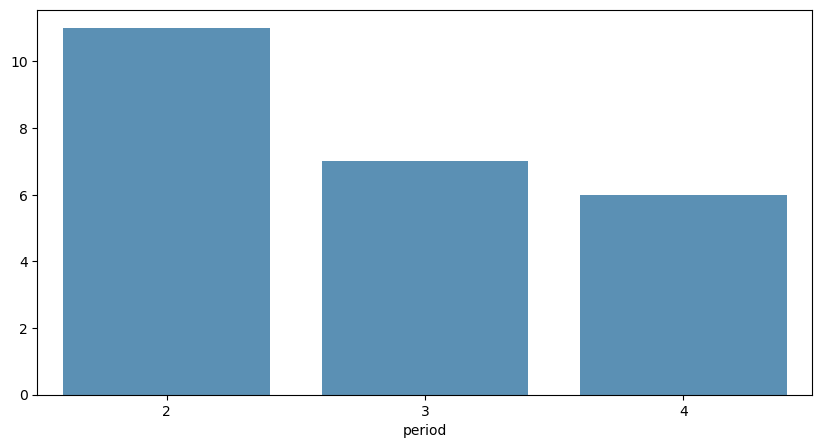

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame and 'period' is a column in your DataFrame
Period_Count = df['period'].value_counts(sort=True).nlargest(3)

# Use named arguments for x and y
plt.figure(figsize=(10, 5))
sns.barplot(x=Period_Count.index, y=Period_Count.values, alpha=0.8)
plt.show()


In [41]:
df9 = df[df['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.mkt_amt.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_out.set_index('name', inplace=True)
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=        shares  ..., width=900)

In [42]:
short_term = (df.period == '4')
df.loc[short_term].head().style.format(format_dict).hide(axis="index")

name,shares,unit_cost,dividend,mkt_price,period,cost_amt,mkt_amt,div_amt,cost_pct,mkt_pct,pft_pct,div_rnk,amt_rnk
CPF,"10,000",฿23.40,฿1.5500,฿21.80,4,"฿234,000.00","฿218,000.00","฿15,500.00",6.62%,7.11%,-6.84%,12.0,9.0
IVL,"7,200",฿40.00,฿0.7000,฿16.10,4,"฿288,000.00","฿115,920.00","฿5,040.00",1.75%,4.35%,-59.75%,23.0,18.0
ORI,"50,000",฿9.00,฿0.0210,฿1.79,4,"฿450,000.00","฿89,500.00","฿1,050.00",0.23%,1.17%,-80.11%,28.0,21.0
PTTGC,"6,000",฿64.75,฿0.5000,฿21.00,4,"฿388,500.00","฿126,000.00","฿3,000.00",0.77%,2.38%,-67.57%,27.0,14.0
SCC,600,฿405.00,฿5.0000,฿183.50,4,"฿243,000.00","฿110,100.00","฿3,000.00",1.23%,2.72%,-54.69%,26.0,19.0


In [43]:
data = df.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'CPF', 'IVL', 'ORI', 'PTTGC', 'SCC', 'SINGER'"

In [44]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
print(sql)

stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks


SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN ('CPF', 'IVL', 'ORI', 'PTTGC', 'SCC', 'SINGER')


,min,price,max
name,,,
CPF,22.70,23.50,27.00
IVL,37.00,41.25,52.75
ORI,9.20,12.00,12.70
PTTGC,39.75,50.00,58.75
SCC,307.00,344.00,402.00
SINGER,26.25,27.50,59.25


In [45]:
#stocks.drop('SCC',inplace=True)
#stocks

In [46]:
stocks.plot.bar()

<Axes: xlabel='name'>

In [47]:
#stocks.reset_index('name',inplace=True)
#sns.barplot(x='name', y='price', data=stocks)

### Portfolio cumulative sum by period, name

In [49]:
colw = 'period name shares unit_cost cost_amt mkt_amt cumsum'.split()
df['cumsum'] = df.groupby('period')['mkt_amt'].cumsum()
df[colw].sort_values(by=['period','name'],ascending=[True,True]).style.format(format_dict).hide(axis="index")

period,name,shares,unit_cost,cost_amt,mkt_amt,cumsum
1,AH,"1,200",฿37.00,"฿44,400.00","฿15,120.00","฿15,120.00"
1,AWC,"9,000",฿4.96,"฿44,640.00","฿19,080.00","฿34,200.00"
1,JMART,"6,800",฿33.00,"฿224,400.00","฿46,920.00","฿81,120.00"
1,JMT,"7,000",฿37.70,"฿263,900.00","฿61,250.00","฿142,370.00"
1,TOA,"1,000",฿26.00,"฿26,000.00","฿13,600.00","฿155,970.00"
2,AIMIRT,"17,500",฿10.60,"฿185,500.00","฿190,750.00","฿190,750.00"
2,CPNREIT,"55,000",฿18.00,"฿990,000.00","฿621,500.00","฿812,250.00"
2,DIF,"45,000",฿12.70,"฿571,500.00","฿425,250.00","฿1,237,500.00"
2,GVREIT,"69,000",฿7.75,"฿534,750.00","฿465,750.00","฿1,703,250.00"
2,MCS,"75,000",฿15.31,"฿1,148,400.00","฿626,250.00","฿2,329,500.00"


In [50]:
df.stb.freq(["period"], value="mkt_amt").style.format(format_dict).hide(axis="index")

period,mkt_amt,percent,cumulative_mkt_amt,cumulative_percent
2,"฿3,514,410.00",55.75%,"฿3,514,410.00",55.75%
3,"฿1,944,635.00",30.85%,"฿5,459,045.00",86.60%
4,"฿688,800.00",10.93%,"฿6,147,845.00",97.53%
1,"฿155,970.00",2.47%,"฿6,303,815.00",100.00%


In [51]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y:%m:%d %H:%M:%S")
print(formatted_time)

2026:01:05 20:25:58
